------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2021-10-26 11:35:49,232
------------------------------------------------------------


1000
2700
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.coords
2     : throat.conns
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.all
2     : pore.back
3     : pore.bottom
4     : pore.front
5     : pore.geo_01
6     : pore.internal
7     : pore.left
8     : pore.right
9     : pore.surface
10    : pore.top
11    : throat.all
12    : throat.geo_01
13    : throat.internal
14    : throat.surface
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
mean pore diameter 2.1188963377533042e-05
min  p

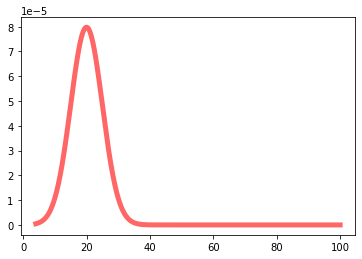

In [1]:
import openpnm as op
import openpnm.models.geometry as gmods
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from scipy.stats import lognorm
from scipy.stats import norm

# Define geometrical parameters
Lc = 1e-4
Nx, Ny, Nz = (10, 10, 10)
Pin, Pout = (2000000, 1000000)
# Generate network, geometry, phase, and physics
#pn = op.network.Cubic(shape=[Nx, Ny, Nz], spacing=Lc,connectivity=26)
#op.topotools.reduce_coordination(network=pn, z=5)

pn = op.network.Cubic(shape=[Nx, Ny, Nz], spacing=Lc,connectivity=6)
#Create a Geometry Object and Assign Geometric Properties to Pores and Throats
#The Network pn does not contain any information about pore and throat sizes at this point. The next step is to create
#a Geometry object to manage the geometrical properties.
#geom = OpenPNM.Geometry.GenericGeometry(network=pn, pores=pn.Ps, throats=pn.Ts)


# test case https://git.iws.uni-stuttgart.de/dumux-repositories/dumux/-/blob/master/examples/porenetwork_upscaling/README.md 
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

npr = pn.num_pores()
print(pn.num_pores())
print(pn.num_throats())
print(pn.props())
print(pn.pores('left'))
print(pn.labels())

geo['pore.old_diameter'] = geo.pop('pore.diameter')
#geo.add_model(propname='pore.diameter',
#              model=gmods.pore_size.weibull,
#              shape=0.5, loc=0, scale=1e-5)
sd = 10
mean = 20
geo.add_model(propname='pore.diameter',
              model=gmods.pore_size.normal,
              loc=mean, scale=sd)
              #loc=5e-5, scale=1e-5)

#s = 0.954
#x = np.linspace(lognorm.ppf(0.01, s),lognorm.ppf(0.99, s), npr)
#mean, var, skew, kurt = 20, 10, 0, 0 #lognorm.stats(s, moments='mvsk')
#geo['pore.diameter'] = lognorm.pdf(x, s)*0.0001
#plt.plot(x, lognorm.pdf(x, s),'r-', lw=5, alpha=0.6, label='lognorm pdf')

x = np.linspace(4, 100, npr)
#y = norm.pdf(x, 20, 10)
geo['pore.diameter'] = norm.pdf(x,20,5)*0.001
plt.plot(x, geo['pore.diameter'],'r-', lw=5, alpha=0.6, label='norm pdf')
plt.savefig('pore_diameter.png')

for i in range(npr):
    #print(geo['pore.diameter'][i])
    if geo['pore.diameter'][i] < 2e-6: 
        geo['pore.diameter'][i] = geo['pore.diameter'].mean()

geo.add_model(propname='throat.diameter',
              model=op.models.misc.from_neighbor_pores,prop='pore.diameter',mode='min')

#geo['throat.diameter'] = geo['throat.diameter']/2.0

#geo.add_model(propname='throat.endpoints',
#                model=op.models.geometry.throat_endpoints.spherical_pores)
#geo.add_model(propname='throat.area',
#                model=op.models.geometry.throat_cross_sectional_area.cylinder)
#geo.add_model(propname='pore.area',
#                model=op.models.geometry.pore_cross_sectional_area.sphere)
#geo.add_model(propname='throat.conduit_lengths',
#                model=op.models.geometry.throat_length.conduit_lengths)
        
#fig = plt.hist(geo['pore.diameter'], bins=15,density=True, edgecolor='k', alpha=0.5) 
print("mean pore diameter", geo['pore.diameter'].mean()) 
print("min  pore diameter", geo['pore.diameter'].min())
print("max  pore diameter", geo['pore.diameter'].max())

print("mean throat diameter", geo['throat.diameter'].mean()) 
print("min  throat diameter", geo['throat.diameter'].min())
print("max  throat diameter", geo['throat.diameter'].max())


#Hg = op.phases.Mercury(network=pn)
#phys = op.physics.Standard(network=pn, phase=Hg, geometry=geo)

# Create algorithm and run simulation
#mip = op.algorithms.Porosimetry(network=pn)
#mip.setup(phase=Hg)
#mip.set_inlets(pores=pn.pores(['left', 'right']))
#mip.run()
print(pn.check_network_health())
print(geo.models)

In [2]:
# Generate phase and physics
water = op.phases.Water(network=pn)
water['pore.viscosity'] =0.001
phys = op.physics.Standard(network=pn, phase=water, geometry=geo)

# Create algorithm, set boundary conditions and run simulation
sf = op.algorithms.StokesFlow(network=pn, phase=water)

sf.set_value_BC(pores=pn.pores('left'), values=Pin)
sf.set_value_BC(pores=pn.pores('right'), values=Pout)
sf.run()
print(water)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.phases.Water : phase_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.contact_angle                             1000 / 1000 
2     pore.critical_pressure                         1000 / 1000 
3     pore.critical_temperature                      1000 / 1000 
4     pore.critical_volume                           1000 / 1000 
5     pore.density                                   1000 / 1000 
6     pore.diffusivity                               1000 / 1000 
7     pore.electrical_conductivity                   1000 / 1000 
8     pore.molar_density                             1000 / 1000 
9     pore.molecular_weight                          1000 / 1000 
10    pore.pressure                                  1000 / 1000 
11    

In [8]:
Q = sf.rate(pores=pn.pores('left'))
A = Ny*Nz*Lc**2
L = Nx*Lc
mu = water['pore.viscosity'].mean()
K = Q*mu*L/(A*(Pin-Pout))
print(K, Q, mu, L, A, Pin-Pout)
print("effective permeability",sf.calc_effective_permeability())
print(Q)

print(pn.shape.max())
print(pn.spacing.max()) 
vol_total = (pn._shape * pn._spacing).prod()
vol_pores = geo['pore.volume'].sum()
vol_throats = geo['throat.volume'].sum()
porosity = (vol_pores + vol_throats) / vol_total * 100
print('Porosity (%):', porosity)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2021-10-26 11:39:34,189
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2021-10-26 11:39:34,190
------------------------------------------------------------


[1.07686716e-13] [1.07686716e-07] 0.0010000000000000005 0.001 1e-06 1000000
effective permeability [1.19651907e-13]
[1.07686716e-07]
10
9.999999999999994e-05
Porosity (%): 10.5016637626335


------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2021-10-26 11:35:52,317
------------------------------------------------------------


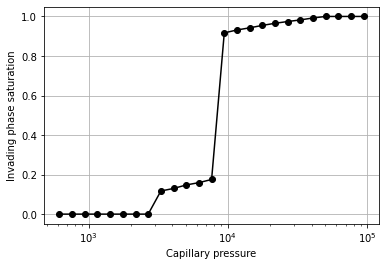

In [4]:
mip = op.algorithms.Porosimetry(network=pn, phase=water)
mip.set_inlets(pores=pn.pores('left'))
mip.run()
fig = mip.plot_intrusion_curve()

mean co-ordination number 5.4
minimum co-ordination number 3
maximum co-ordination number 6


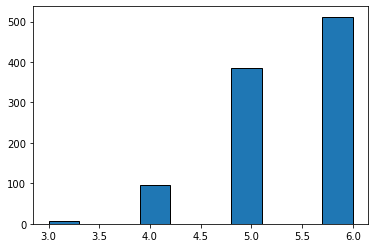

In [5]:
fig = plt.figure()
plt.hist(pn.num_neighbors(pn.Ps), edgecolor='k')
fig.patch.set_facecolor('white')
print("mean co-ordination number",pn.num_neighbors(pn.Ps).mean())
print("minimum co-ordination number",pn.num_neighbors(pn.Ps).min())
print("maximum co-ordination number",pn.num_neighbors(pn.Ps).max())